In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


這次的範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter07/random_walk.py)

Chapter 8主要結合planning與learning，讓過往的經驗可以再次得到一次利用

Example 8.1: Dyna Maze

下面給出一個簡單的迷宮：
![](https://i.imgur.com/pwVihdo.png)


Figure 8.2: 一個簡單的迷宮(插圖)與Dyna-Q agent的平均學習曲線，每個real step不同的planning steps ($n$)計算而得。這個任務是要從$S$移動到$G$，愈快愈好。

1. 這47個states(6\*9-7個障礙物)都有四個actions，也就是上、下、左、右。如果碰到障礙物(深色的部份)或是邊緣那就停在原地，不然agent一樣是四面八方都可以隨便亂走
2. 每次的轉移得到的reward都是0，如果進入目標狀態那reward就是+1
3. 每次到達目標狀態$G$之後，agent就會回到起始狀態$S$來開始一個新的episode
4. discount，$\lambda = 0.95$

Figure 8.2的主要部份說明著應用Dyna-Q agents到這個迷宮任務的平均學習曲線：
* 初始的action values為0，
* step-size $\alpha=0.1$
* $\epsilon=0.1$

當我們貪燹(greediy)的選擇著actions的時候，ties were broken randomly(這邊翻不出來，是指相同機率的時候就隨機選擇嗎?)。agent的planning steps $n$會各自不同，會在每個real step執行。對每一個$n$，曲線說明著agent在每個episodes到達目標所採取的steps的數量，平均超過30次的反覆實驗。在每次的實驗過程中，random seed是維持不變的。因為這樣，不管你的$n$為何，第一個episode是完全相同的(約1700 steps)，所以它的資料就沒有呈現在圖表上。第一個episode之後，不管$n$值為何，效能都提升了，值得注意的是，對於$n$值較大的數值，效能提升的更快。回頭想想，當$n=0$的時候，agent就是一個nonplanning的agent，就只是一個direct RL(one-step tabular Q-learning)。這是就這問題上，當今世上最慢的agent，儘管它的參數($\alpha, \epsilon$)已經是最好的，依然如此。這個nonplanning agent大概需要25個episodes才能來到$(\epsilon-)$optimal，然後，當$n=5$的時候就大概需要5個episodes，$n=50$的時候就只需要3個episodes。

Figure 8.3說明著為什麼planning agent找出解的速度會比nonplanning agent還要來的快的原因。兩張圖各自是$n=0, n=50$在第二個episodes的途中找出來的解。沒有planning，也就是$n=0$的情況下，每個episodes就只會增加額外的一個step到policy，所以目前為止就只學到一個step，也就是最後那個step。不過當你用planning的時候，雖然第一個episode一樣是只學習到一個step，但是在第二個episode的過程中就已經弄出一個非常廣泛的策略(extensive policy)，你已經幾乎可以從目標狀態回到起始狀態了。到第三個episode結束的時候，你已經可以找到一個optimal policy，而且效能完美。


![](https://i.imgur.com/XirykSU.png)

Figure 8.3: Dyna-Q agent在第二個episode途中所找到的policy(nonplanning、planning)。箭頭指出的是每個state的greedy action；如果某一個state沒有箭頭，那就代表所有的action values都是相等的。黑色區域代表agent的所在區域。

首先載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

首先設置Environment

In [3]:
class Maze:
    def __init__(self):
        """初始化環境
        
        根據範例說明：
        1. 這是一個寬9高6的gridworld
        2. 每個episode的start state都是[2, 0]
        3. goal state為[8, 0]
        4. 我們能做的action就是上下左右
        5. 路面上是有障礙
        """
        self.WORLD_WIDTH = 9
        self.WORLD_HEIGHT = 6
        
        self.START_STATE = [2, 0]
        self.GOAL_STATE = [0, 8]
        
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.action_space = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]
        # 障礙設置
        self.obstacles = [[1, 2], [2, 2], [3, 2], 
                          [4, 5], 
                          [0, 7], [1, 7], [2, 7]]
        
        self.value_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.action_space))
        
        self.max_steps = float('inf')
        
    def step(self, state, action):
        """run step according action
        
        state: 當前的狀態
        action: 要執行的action
        
        幾點要注意：
            1. 不能超出邊界，這可以用max、min來處理
            2. 撞到障礙就是停在原地
            3. 每次的reward都是0，除非你到達goal state
            
        return next_state, reward
        """
        x, y = state
        
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif  action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif  action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif  action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        
        if [x, y] in self.obstacles:
            x, y = state
        
        if [x, y] == self.GOAL_STATE:
            reward = 1.0
        else:
            reward = 0.0
        
        return [x, y], reward
        

In [4]:
maze = Maze()
assert maze.START_STATE == [2, 0]
assert (maze.step([2, 0], 0)) == ([1, 0], 0)

In [5]:
maze.GOAL_STATE

[0, 8]

然後我們會需要一個model來記錄曾經有過的經驗

In [6]:
class TrivialModel:
    def __init__(self, rand=np.random):
        # 用dict來做模型，反正我們只會記錄該state-action pair最後一次的經驗
        self.model = dict()
        self.rand = rand
        self.rand.seed(10)
    
    def feed(self, state, action, next_state, reward):
        """記錄經驗"""
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        # 判斷該組state是否存在目前的model
        # 如不存在就賦予一個預設值
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]
        
    def sample(self):
        """隨機取一筆經驗出來再做更新"""
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

然後我們來設置一下Dyna-Q所需要的參數：
* gamma: discount factor
* epsilon: 探索的機率
* planning_steps: planning steps
* average_runs: 幾次的run計算平均

In [7]:
dyna_q_params = {
    'gamma': 0.95,
    'epsilon': 0.1,
    'planning_steps': 5,
    'average_runs': 10,     
    'alpha': 0.1
}

設置一個已經很熟悉的，用來選擇action的function

In [8]:
def action_selection(state, q_values, maze, dyna_params):
    """選擇action的function
    
    state: current state
    q_values: value function
    maze: object for Maze
    dyna_params: algorithm's parameters
    """
    if np.random.binomial(1, dyna_q_params['epsilon']) == 1:
        return np.random.choice(maze.action_space)
    else:
        # 取得該state的所有可能的action
        values = q_values[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])
    

接著來設置Dyna-Q algorithm，下面給出完整演算法的pseudocode

![](https://i.imgur.com/jo168Rh.png)

In [9]:
def dyna_q_algorithm(q_values, model, maze, params):
    """dyna_q algorithm
    
    q_values: action-value function
    model: for planning
    maze: environment
    params: for dyna_q's parameters
    
    見上演算法說明
    """
    # (a) current state
    state = maze.START_STATE
    steps = 0
    
    # 一直到agent走到目標之前就是一路迴圈執行
    while state != maze.GOAL_STATE:        
        # 記錄當下的steps
        steps += 1
        
        # (b) 取得action
        action = action_selection(state, q_values, maze, params)
        
        # (c) 執行action，得到next state與reward
        next_state, reward = maze.step(state, action)
        
        # (d) 做一次Q-learning的更新
        q_value[state[0], state[1], action] += \
            params['alpha'] * (reward + params['gamma'] * np.max(q_values[next_state[0], next_state[1], :]) \
                - q_values[state[0], state[1], action])
        
        # (e) 資料寫入模型
        model.feed(state, action, next_state, reward)
        
        # (f) 迴圈執行planning_steps次
        for t in range(0, params['planning_steps']):            
            # 隨機的從模型中取一筆資料
            # 從經驗中學習，其實就是用sample到的資料再做一次更新
            _state, _action, _next_state, _reward = model.sample()
            q_value[_state[0], _state[1], _action] += \
            params['alpha'] * (_reward + params['gamma'] * np.max(q_values[_next_state[0], _next_state[1], :]) \
                - q_values[_state[0], _state[1], _action])
            
        state = next_state
        
        if steps > maze.max_steps:
            break
    
    return steps

演算法的部份也已經好了，現在我們可以來處理實際要執行的過程了

首先初始化需求的物件

In [10]:
dynaQ_maze = Maze()

然後我們也已經有env的參數

In [11]:
dyna_q_params

{'gamma': 0.95,
 'epsilon': 0.1,
 'planning_steps': 5,
 'average_runs': 10,
 'alpha': 0.1}

接下來設置一些過程中需要的參數

In [12]:
runs = 30 # 執行幾次
episodes = 50 # 跑幾個episode
planning_steps = [0, 5, 50] # 不同的plannint steps
steps = np.zeros((len(planning_steps), episodes)) # 要比較不同planning step的結果

In [13]:
steps.shape

(3, 50)

In [14]:
%%time
for run in tqdm(range(runs)):    
    for i, planning_step in enumerate(planning_steps):        
        dyna_q_params['planning_steps'] = planning_step
        # 初始化action-value function
        q_value = np.zeros(dynaQ_maze.value_size)        
        # 初始化一個model，在這邊初始化是因為我們要分多個planning steps來記錄
        model = TrivialModel()
        
        for episode in range(episodes):                        
            steps[i, episode] += dyna_q_algorithm(q_value, model, dynaQ_maze, dyna_q_params)
            

100%|██████████| 30/30 [01:54<00:00,  3.80s/it]

CPU times: user 1min 54s, sys: 530 ms, total: 1min 54s
Wall time: 1min 54s


計算平均

In [15]:
steps /= runs

繪製圖面

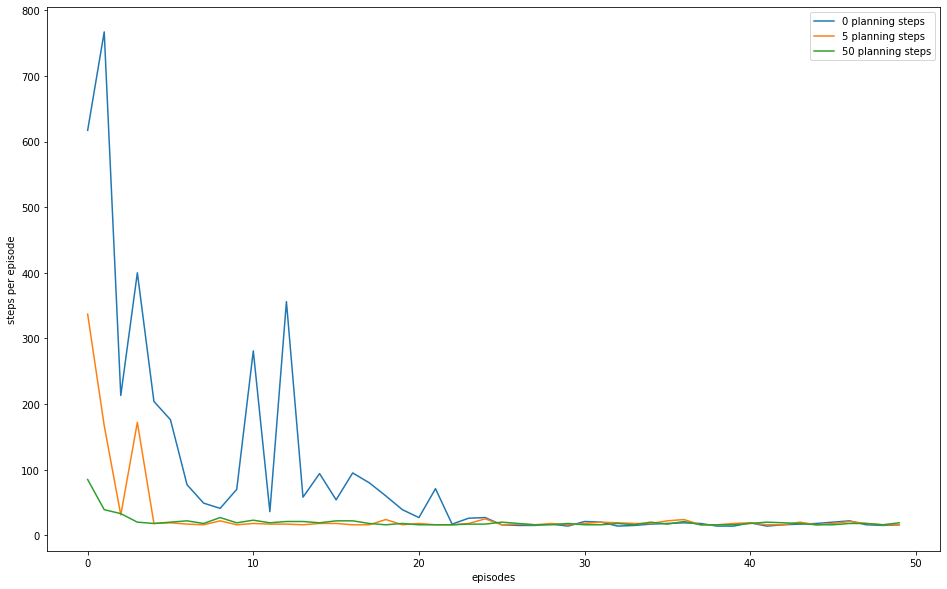

In [16]:
plt.figure(figsize=(16, 10))
for i in range(len(planning_steps)):
    plt.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]))

plt.xlabel('episodes')
plt.ylabel('steps per episode')
plt.legend()
plt.show()

把policy繪製出來

In [17]:
ACTION_FLAGS=['↑', '↓', '←', '→'] 

In [18]:
from matplotlib.table import Table

def draw_policy(q_values, maze):
    """
    繪製policy
    
    q_values: action-value function
    maze: Maze object
    """
    fig, ax = plt.subplots()
    ax.set_axis_off() # 隱藏圖表的軸線
    tb = Table(ax) # new一個Table object
    
    # 設置表格大小
    nrows, ncols = q_values.shape[0: 2]
    width = 1.0 / ncols
    height = 1.0 / nrows
    
    # loop action-value function
    for i in range(nrows):
        for j in range(ncols):
            # 取得最佳的action index
            best_action = np.argmax(q_values[i, j, :])
            
            action_flag = ACTION_FLAGS[best_action]
            
            if [i, j] == maze.START_STATE:
                action_flag = 'S'
            elif [i, j] == maze.GOAL_STATE:
                action_flag = 'G'
            elif [i, j] in maze.obstacles:
                action_flag = 'W'
            
            tb.add_cell(i, j, width, height, text=action_flag, loc='center', facecolor='white')
            
    ax.add_table(tb)

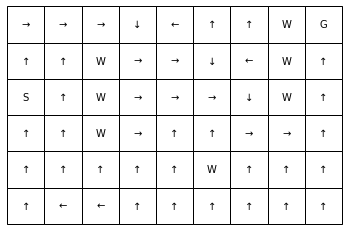

In [19]:
draw_policy(q_value, maze)